In [1]:
!pip install --upgrade pandas scikit-learn scipy textblob spacy folium geopy

  Using cached numpy-2.0.2-cp39-cp39-macosx_10_9_x86_64.whl (21.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
streamlit 1.21.0 requires pandas<2,>=0.25, but you have pandas 2.2.3 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [2]:
!pip install "numpy<2"

  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
streamlit 1.21.0 requires pandas<2,>=0.25, but you have pandas 2.2.3 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.4 which is incompatible.
blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
import pandas
import sklearn

# print("NumPy version:", numpy.__version__)
print("Pandas version:", pandas.__version__)
print("Scikit-learn version:", sklearn.__version__)


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Pandas version: 2.2.3
Scikit-learn version: 1.5.2


In [4]:
# libraries for handling data and visualization
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from geopy.geocoders import Nominatim
import numpy as np

In [5]:
import pandas as pd
import csv
import sys

# Increase parser's field size limit to handle long rows
csv.field_size_limit(sys.maxsize)

def load_large_csv(file_path):
    """
    Safely load a large CSV file by handling bad lines and using an optimized method.
    """
    try:
        print(f"Attempting to load {file_path}...")

        # Load the CSV file using a robust approach
        df = pd.read_csv(
            file_path,
            on_bad_lines='skip',  # Skip malformed rows
            encoding='utf-8',  # Use UTF-8 encoding
            engine='python'  # Python engine for better error handling
        )

        print(f"Successfully loaded {len(df)} rows from {file_path}")
        return df

    except pd.errors.ParserError as e:
        print(f"ParserError: {e}")
        print("Retrying with smaller chunks...")
        # Fallback: Process the file in smaller chunks
        chunks = []
        with pd.read_csv(
            file_path,
            on_bad_lines='skip',
            encoding='utf-8',
            engine='python',
            chunksize=10000
        ) as reader:
            for chunk in reader:
                chunks.append(chunk)
        df = pd.concat(chunks, ignore_index=True)
        print(f"Successfully loaded {len(df)} rows in chunks from {file_path}")
        return df

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


# Load the Trump tweets dataset
print("TRUMP TWEETS")
df_trump = load_large_csv('hashtag_donaldtrump.csv')
if df_trump is not None:
    print(f"Trump dataset loaded with {len(df_trump)} rows.")
    print(df_trump.head())

# Load the Biden tweets dataset
print("\nBIDEN TWEETS")
df_biden = load_large_csv('hashtag_joebiden.csv')
if df_biden is not None:
    print(f"Biden dataset loaded with {len(df_biden)} rows.")
    print(df_biden.head())


TRUMP TWEETS
Attempting to load hashtag_donaldtrump.csv...
Successfully loaded 971087 rows from hashtag_donaldtrump.csv
Trump dataset loaded with 971087 rows.
            created_at                tweet_id  \
0  2020-10-15 00:00:01   1.316529221557252e+18   
1  2020-10-15 00:00:01  1.3165292227484303e+18   
2  2020-10-15 00:00:02   1.316529228091847e+18   
3  2020-10-15 00:00:02   1.316529227471237e+18   
4  2020-10-15 00:00:08  1.3165292523014513e+18   

                                               tweet likes  retweet_count  \
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...   0.0            0.0   
1  Usa 2020, Trump contro Facebook e Twitter: cop...  26.0            9.0   
2  #Trump: As a student I used to hear for years,...   2.0            1.0   
3  2 hours since last tweet from #Trump! Maybe he...   0.0            0.0   
4  You get a tie! And you get a tie! #Trump ‘s ra...   4.0            3.0   

               source               user_id              user_name  \
0      

In [6]:
df_combined = pd.concat([df_trump, df_biden])

In [7]:
### step 1: clean up the tweets ###
def clean_text(text):
    if not isinstance(text, str):
        return ""  # return an empty string for non-string inputs
    text = re.sub(r"http\S+", "", text)  # get rid of links
    text = re.sub(r"#\w+", "", text)  # remove hashtags
    text = re.sub(r"@\w+", "", text)  # strip out mentions
    text = re.sub(r"[^\w\s]", "", text)  # ditch punctuation
    return text.lower()  # make everything lowercase

# apply the cleaning function
df_combined['cleaned_tweet'] = df_combined['tweet'].apply(clean_text)

In [8]:
### step 2: do some sentiment analysis ###
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df_combined['sentiment'] = df_combined['cleaned_tweet'].apply(get_sentiment)

In [9]:
# throw tweets into buckets: positive, neutral, negative
df_combined['sentiment_category'] = pd.cut(
    df_combined['sentiment'], 
    bins=[-1, -0.05, 0.05, 1], 
    labels=['negative', 'neutral', 'positive']
)

In [10]:
### step 3: vectorize the text with tf-idf ###
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_combined['cleaned_tweet'])


In [11]:
### step 4: cluster tweets using kmeans ###
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_combined['cluster'] = kmeans.fit_predict(tfidf_matrix)

/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [12]:
# check out the top words for each cluster
print("top terms per cluster:")
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    cluster_terms = [terms[ind] for ind in kmeans.cluster_centers_[i].argsort()[-10:]]
    print(f"cluster {i}: {', '.join(cluster_terms)}")


top terms per cluster:
cluster 0: arizona, votes, en, georgia, nevada, pennsylvania, trump, biden, wisconsin, michigan
cluster 1: election, just, que, en, joe, president, amp, la, biden, trump
cluster 2: just, won, biden, america, people, amp, day, president, im, happy
cluster 3: count, like, election, people, dont, america, biden, amp, trump, vote
cluster 4: doesnt, believe, president, like, just, people, say, trump, amp, true


In [13]:
### step 5: make a heatmap to show where tweets are coming from ###
# grab tweets with location info
geo_tweets = df_combined.dropna(subset=['lat', 'long'])

In [14]:
# make a base map
map_tweets = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

In [36]:
# # filter for rows with valid numeric latitude and longitude values
# geo_tweets = geo_tweets[
#     geo_tweets['lat'].apply(lambda x: isinstance(x, (int, float))) &
#     geo_tweets['long'].apply(lambda x: isinstance(x, (int, float)))
# ]

# # add heatmaps for sentiment categories
# for sentiment in ['positive', 'neutral', 'negative']:
#     sentiment_tweets = geo_tweets[geo_tweets['sentiment_category'] == sentiment]
#     heat_data = sentiment_tweets[['lat', 'long']].values.tolist()
#     HeatMap(heat_data, name=f"{sentiment.capitalize()} Sentiment").add_to(map_tweets)

# # add a way to toggle layers on/off
# folium.LayerControl().add_to(map_tweets)

# # save the map so you can open it later
# map_tweets.save('tweets_sentiment_map.html')

In [16]:
from wordcloud import WordCloud

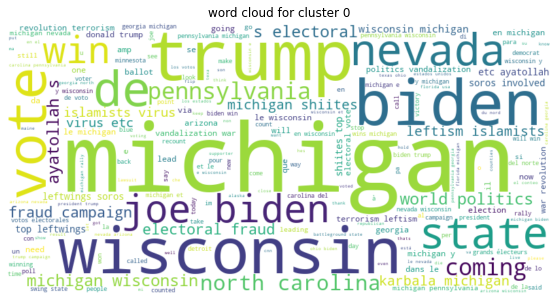

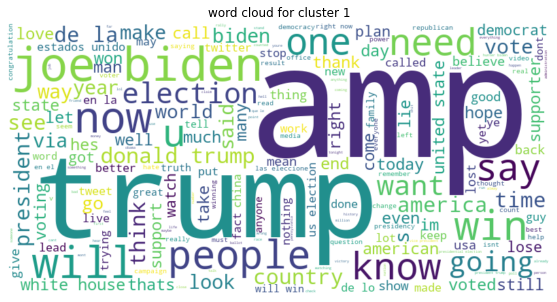

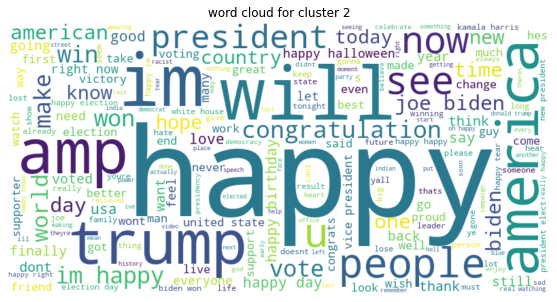

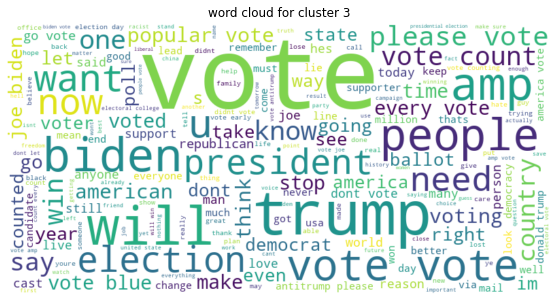

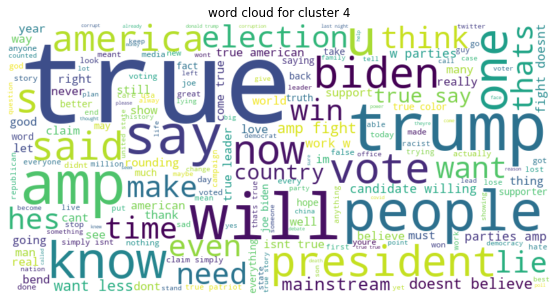

In [17]:
### step 5: evaluate with some word clouds ###
# make word clouds for each cluster
for i in range(num_clusters):
    cluster_tweets = df_combined[df_combined['cluster'] == i]['cleaned_tweet']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_tweets))
    plt.figure(figsize=(10, 5))
    plt.title(f"word cloud for cluster {i}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

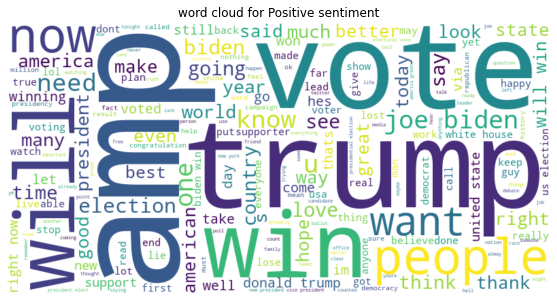

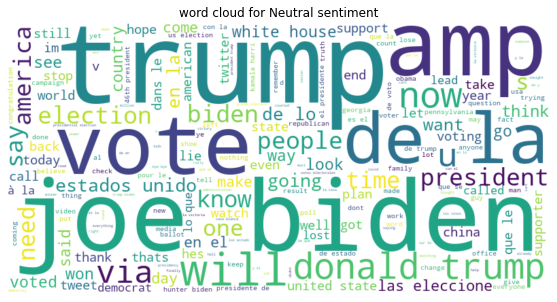

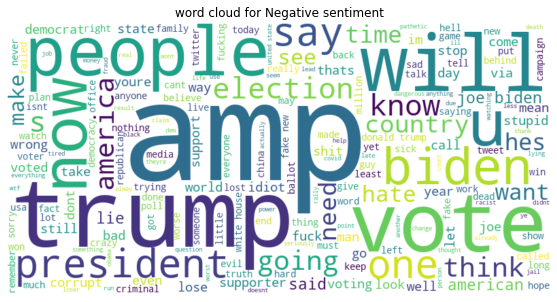

In [37]:
# now do word clouds for sentiment categories
for sentiment in ['positive', 'neutral', 'negative']:
    sentiment_tweets = df_combined[df_combined['sentiment_category'] == sentiment]['cleaned_tweet']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sentiment_tweets))
    plt.figure(figsize=(10, 5))
    plt.title(f"word cloud for {sentiment.capitalize()} sentiment")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [19]:
# count tweets with valid latitude and longitude
tweets_with_location = df_combined.dropna(subset=['lat', 'long']).shape[0]

# print the result
print(f"Number of tweets with geolocation data: {tweets_with_location}")


Number of tweets with geolocation data: 800986


In [20]:
total_tweets = df_combined.shape[0]
percentage_with_location = (tweets_with_location / total_tweets) * 100

print(f"Percentage of tweets with geolocation data: {percentage_with_location:.2f}%")


Percentage of tweets with geolocation data: 45.82%


In [21]:
# ATTEMPT ONE: COLOURED HEAT MAP - NOT THE FINAL VERSION

import pandas as pd
import folium
from folium.plugins import HeatMap

# use the combined dataset
geo_tweets = df_combined

# filter tweets with valid lat/long
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# make sure lat/long are numeric
geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')

# drop rows with invalid lat/long values
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# define political issues and keywords
issue_keywords = {
    'economics': ['economy', 'jobs', 'inflation', 'tax', 'budget'],
    'womens_rights': ['abortion', 'women', 'rights', 'gender', 'feminism'],
    'immigration': ['border', 'immigration', 'migrant', 'visa', 'asylum'],
    'policy': ['healthcare', 'education', 'policy', 'law', 'reform']
}

# function to classify tweets into issues
def classify_issue(tweet):
    for issue, keywords in issue_keywords.items():
        if any(keyword in tweet.lower() for keyword in keywords):
            return issue
    return 'other'

# clean tweet text if needed and classify
geo_tweets['cleaned_tweet'] = geo_tweets['tweet'].str.lower().fillna('')
geo_tweets['issue_category'] = geo_tweets['cleaned_tweet'].apply(classify_issue)

# create a map
map_issues = folium.Map(location=[0, 0], zoom_start=2)

# add a heatmap for each issue with a unique gradient color
issue_colors = {
    'economics': {'0.0': 'blue', '0.5': 'cyan', '1.0': 'green'},
    'womens_rights': {'0.0': 'purple', '0.5': 'pink', '1.0': 'red'},
    'immigration': {'0.0': 'brown', '0.5': 'orange', '1.0': 'yellow'},
    'policy': {'0.0': 'gray', '0.5': 'lightblue', '1.0': 'darkblue'}
}

for issue, colors in issue_colors.items():
    issue_tweets = geo_tweets[geo_tweets['issue_category'] == issue]
    heat_data = issue_tweets[['lat', 'long']].values.tolist()
    HeatMap(heat_data, name=f"{issue.capitalize()} Issue", gradient=colors).add_to(map_issues)

# add layer control to toggle between issues
folium.LayerControl().add_to(map_issues)

# save the map
map_issues.save('tweets_issues_coloured_map.html')
print("coloured heatmap for political issues saved as 'tweets_issues_coloured_map.html'")


/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/3511168760.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/3511168760.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')


coloured heatmap for political issues saved as 'tweets_issues_coloured_map.html'


In [22]:
# ATTEMPT TWO: WITH MARKERS, BUT TOO MANY "OTHER" - HARD TO SEE WHAT'S IMPORTANT. - NOT FINAL
# Additionally, it assumes the mention of specific words.

import pandas as pd
import folium

# use the combined dataset
geo_tweets = df_combined

# filter tweets with valid lat/long
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# make sure lat/long are numeric
geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')

# drop rows with invalid lat/long values
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# define political issues and keywords
issue_keywords = {
    'economics': ['economy', 'jobs', 'inflation', 'tax', 'budget'],
    'womens_rights': ['abortion', 'women', 'rights', 'gender', 'feminism'],
    'immigration': ['border', 'immigration', 'migrant', 'visa', 'asylum'],
    'policy': ['healthcare', 'education', 'policy', 'law', 'reform']
}

# function to classify tweets into issues
def classify_issue(tweet):
    for issue, keywords in issue_keywords.items():
        if any(keyword in tweet.lower() for keyword in keywords):
            return issue
    return 'other'

# clean tweet text if needed and classify
geo_tweets['cleaned_tweet'] = geo_tweets['tweet'].str.lower().fillna('')
geo_tweets['issue_category'] = geo_tweets['cleaned_tweet'].apply(classify_issue)

# group by city and find the most discussed issue for each city
city_issues = (
    geo_tweets.groupby(['city', 'lat', 'long'])['issue_category']
    .apply(lambda x: x.value_counts().idxmax())
    .reset_index(name='dominant_issue')
)

# create a map centered on the US
city_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

# color mapping for issues
issue_colors = {
    'economics': 'blue',
    'womens_rights': 'pink',
    'immigration': 'orange',
    'policy': 'green',
    'other': 'gray'
}

# add a marker for each city
for _, row in city_issues.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"City: {row['city']}<br>Dominant Issue: {row['dominant_issue'].capitalize()}",
        icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))
    ).add_to(city_map)

# save the map
city_map.save('tweets_city_issues_map.html')
print("City-level dominant issue map saved as 'tweets_city_issues_map.html'")

/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/805140645.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/805140645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')


City-level dominant issue map saved as 'tweets_city_issues_map.html'


In [34]:
# from transformers import pipeline
# import pandas as pd
# import folium
# from tqdm import tqdm

# # use the combined dataset
# geo_tweets = df_combined

# # filter tweets with valid lat/long
# geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# # make sure lat/long are numeric
# geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
# geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')

# # drop rows with invalid lat/long values
# geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# # ensure likes column is numeric
# geo_tweets['likes'] = pd.to_numeric(geo_tweets['likes'], errors='coerce')

# # drop rows where likes are still NaN after conversion
# geo_tweets = geo_tweets.dropna(subset=['likes'])

# # sort tweets by likes and take the top X most liked tweets
# top_liked_tweets = geo_tweets.nlargest(5000, 'likes')  # adjust 5000 as needed

# # load a pre-trained text classification model
# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# # updated categories for classification
# categories = [
#     'economy', 'health care', 'supreme court appointments', 
#     'the coronavirus outbreak', 'violent crime', 'foreign policy', 
#     'gun policy', 'race and ethnic inequality', 'immigration', 
#     'economic inequality', 'climate change', 'abortion'
# ]

# # function to classify tweets using the updated categories
# def classify_tweet(tweet):
#     try:
#         # classify tweet into the updated categories
#         result = classifier(tweet, categories)
#         return result['labels'][0]  # return the top category
#     except Exception as e:
#         return 'other'

# # apply the classifier to the most liked tweets with a progress bar
# tqdm.pandas(desc="Classifying tweets")
# top_liked_tweets['issue_category'] = top_liked_tweets['tweet'].progress_apply(classify_tweet)

# # group by city and find the most discussed issue for each city
# city_issues = (
#     top_liked_tweets.groupby(['city', 'lat', 'long'])['issue_category']
#     .apply(lambda x: x.value_counts().idxmax())
#     .reset_index(name='dominant_issue')
# )

# # create a map centered on the US
# city_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

# # color mapping for the new issues
# issue_colors = {
#     'economy': 'blue',
#     'health care': 'green',
#     'supreme court appointments': 'purple',
#     'the coronavirus outbreak': 'red',
#     'violent crime': 'black',
#     'foreign policy': 'orange',
#     'gun policy': 'darkred',
#     'race and ethnic inequality': 'pink',
#     'immigration': 'yellow',
#     'economic inequality': 'cyan',
#     'climate change': 'darkgreen',
#     'abortion': 'darkblue',
#     'other': 'gray'
# }

# # add a marker for each city
# for _, row in city_issues.iterrows():
#     folium.Marker(
#         location=[row['lat'], row['long']],
#         popup=f"City: {row['city']}<br>Dominant Issue: {row['dominant_issue'].capitalize()}",
#         icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))
#     ).add_to(city_map)

# # save the map
# city_map.save('tweets_city_issues_updated_map.html')
# print("City-level dominant issue map with updated categories saved as 'tweets_city_issues_updated_map.html'")

In [27]:
# ATTEMPT THREE - NOT FINAL
# WITH MARKERS, TOP-5000-LIKED TWEETS, NO OTHER, BUT TOO MANY UNDER "POLICY" TO UNDERSTAND.
# RAISES THE QUESTION OF "WHAT POLICY?"

from transformers import pipeline
import pandas as pd
import folium
from tqdm import tqdm

# use the combined dataset
geo_tweets = df_combined

# filter tweets with valid lat/long
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# make sure lat/long are numeric
geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')

# drop rows with invalid lat/long values
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# ensure likes column is numeric
geo_tweets['likes'] = pd.to_numeric(geo_tweets['likes'], errors='coerce')

# drop rows where likes are still NaN after conversion
geo_tweets = geo_tweets.dropna(subset=['likes'])

# sort tweets by likes and take the top X most liked tweets
top_liked_tweets = geo_tweets.nlargest(5000, 'likes')  # adjust 5000 to a reasonable number

# load a pre-trained text classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# define categories for classification
categories = ['economics', 'women\'s rights', 'immigration', 'policy']

# initialize tqdm for progress bar
tqdm.pandas()

# function to classify tweets using the model
def classify_tweet(tweet):
    try:
        # classify tweet into predefined categories
        result = classifier(tweet, categories)
        return result['labels'][0]  # return the top category
    except Exception as e:
        return 'other'

# apply the classifier to the most liked tweets with a progress bar
top_liked_tweets['issue_category'] = top_liked_tweets['tweet'].progress_apply(classify_tweet)

# group by city and find the most discussed issue for each city
city_issues = (
    top_liked_tweets.groupby(['city', 'lat', 'long'])['issue_category']
    .apply(lambda x: x.value_counts().idxmax())
    .reset_index(name='dominant_issue')
)

# create a map centered on the US
city_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

# color mapping for issues
issue_colors = {
    'economics': 'blue',
    'women\'s rights': 'pink',
    'immigration': 'orange',
    'policy': 'green',
    'other': 'gray'
}

# add a marker for each city
for _, row in city_issues.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"City: {row['city']}<br>Dominant Issue: {row['dominant_issue'].capitalize()}",
        icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))
    ).add_to(city_map)

# save the map
city_map.save('tweets_city_issues_top_liked_map.html')
print("City-level dominant issue map for top liked tweets saved as 'tweets_city_issues_top_liked_map.html'")

/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/3030865174.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/3030865174.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')
Device set to use mps:0
100%|███████████████████████████████████████| 5000/5000 [23:41<00:00,  3.52it/s]


City-level dominant issue map for top liked tweets saved as 'tweets_city_issues_top_liked_map.html'


In [39]:
# ATTEMPT FOUR - Close to final version!
# Top-5000 tweets, more categories (top importance to voters as per Pew Research Center)
    # Code will use Facebook's Bart to classify into the categories mentioned above.
from transformers import pipeline
import pandas as pd
import folium
from tqdm import tqdm

In [32]:
# use the combined dataset
geo_tweets = df_combined

# filter tweets with valid lat/long
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# make sure lat/long are numeric
geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')

# drop rows with invalid lat/long values
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# ensure likes column is numeric
geo_tweets['likes'] = pd.to_numeric(geo_tweets['likes'], errors='coerce')

# drop rows where likes are still NaN after conversion
geo_tweets = geo_tweets.dropna(subset=['likes'])

# sort tweets by likes and take the top X most liked tweets
top_liked_tweets = geo_tweets.nlargest(5000, 'likes')  # adjust 5000 as needed

/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/2322224181.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/2322224181.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')


In [33]:
# load a pre-trained text classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# categories for classification: based on Pew Research Center
# https://www.pewresearch.org/politics/2020/08/13/important-issues-in-the-2020-election/

categories = [
    'economy', 'health care', 'supreme court appointments', 
    'the coronavirus outbreak', 'violent crime', 'foreign policy', 
    'gun policy', 'race and ethnic inequality', 'immigration', 
    'economic inequality', 'climate change', 'abortion'
]

# function to classify tweets using the updated categories
def classify_tweet(tweet):
    try:
        # classify tweet into the updated categories
        result = classifier(tweet, categories)
        return result['labels'][0]  # return the top category
    except Exception as e:
        return 'other'

# apply the classifier to the most liked tweets with a progress bar
tqdm.pandas(desc="Classifying tweets")
top_liked_tweets['issue_category'] = top_liked_tweets['tweet'].progress_apply(classify_tweet)

# group by city and find the most discussed issue for each city
city_issues = (
    top_liked_tweets.groupby(['city', 'lat', 'long'])['issue_category']
    .apply(lambda x: x.value_counts().idxmax())
    .reset_index(name='dominant_issue')
)

# create a map centered on the US
city_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

# color mapping for the new issues
issue_colors = {
    'economy': 'blue',
    'health care': 'green',
    'supreme court appointments': 'purple',
    'the coronavirus outbreak': 'red',
    'violent crime': 'black',
    'foreign policy': 'orange',
    'gun policy': 'darkred',
    'race and ethnic inequality': 'pink',
    'immigration': 'yellow',
    'economic inequality': 'cyan',
    'climate change': 'darkgreen',
    'abortion': 'darkblue',
    'other': 'gray'
}

# add a marker for each city
for _, row in city_issues.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"City: {row['city']}<br>Dominant Issue: {row['dominant_issue'].capitalize()}",
        icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))
    ).add_to(city_map)

# save the map
city_map.save('tweets_city_issues_updated_map.html')
print("City-level dominant issue map with updated categories saved as 'tweets_city_issues_updated_map.html'")


Device set to use mps:0
Classifying tweets: 100%|█████████████████| 5000/5000 [1:13:16<00:00,  1.14it/s]
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/40833839.py:59: UserWarning: color argument of Icon should be one of: {'white', 'darkgreen', 'orange', 'red', 'cadetblue', 'green', 'lightred', 'darkpurple', 'blue', 'lightgray', 'darkred', 'lightgreen', 'pink', 'gray', 'darkblue', 'purple', 'lightblue', 'beige', 'black'}.
  icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))


City-level dominant issue map with updated categories saved as 'tweets_city_issues_updated_map.html'


In [35]:
# THIS IS THE FINAL VERSION!!

# This version involves:
    # Top 5000 liked tweets
    # Markers of different colours for each issue (picked from Pew Research Center)
    # By city
    # Alignment of tweets from the city
    
from transformers import pipeline
import pandas as pd
import folium
from tqdm import tqdm

# use the combined dataset
geo_tweets = df_combined

# filter tweets with valid lat/long
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# make sure lat/long are numeric
geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')

# drop rows with invalid lat/long values
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# ensure likes column is numeric
geo_tweets['likes'] = pd.to_numeric(geo_tweets['likes'], errors='coerce')

# drop rows where likes are still NaN after conversion
geo_tweets = geo_tweets.dropna(subset=['likes'])

# sort tweets by likes and take the top X most liked tweets
top_liked_tweets = geo_tweets.nlargest(5000, 'likes')  # adjust 5000 as needed


# load pre-trained models for text classification and sentiment analysis
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
sentiment_analyzer = pipeline("sentiment-analysis")

# categories for classification: based on Pew Research Center
categories = [
    'economy', 'health care', 'supreme court appointments', 
    'the coronavirus outbreak', 'violent crime', 'foreign policy', 
    'gun policy', 'race and ethnic inequality', 'immigration', 
    'economic inequality', 'climate change', 'abortion'
]

# function to classify tweets into categories and analyze sentiment
def classify_tweet_and_sentiment(tweet):
    try:
        # classify tweet into categories
        category_result = classifier(tweet, categories)
        issue_category = category_result['labels'][0]

        # analyze tweet sentiment
        sentiment_result = sentiment_analyzer(tweet)
        sentiment = sentiment_result[0]['label'].lower()  # "positive", "negative", or "neutral"

        # determine alignment (mentioning Biden/Trump positively or negatively)
        alignment = "neutral"
        if 'biden' in tweet.lower():
            alignment = f"{sentiment} toward Biden"
        elif 'trump' in tweet.lower():
            alignment = f"{sentiment} toward Trump"

        return issue_category, sentiment, alignment
    except Exception as e:
        return 'other', 'neutral', 'neutral'

# apply the classifier to the most liked tweets with a progress bar
tqdm.pandas(desc="Classifying tweets")
top_liked_tweets[['issue_category', 'sentiment', 'alignment']] = top_liked_tweets['tweet'].progress_apply(
    lambda tweet: pd.Series(classify_tweet_and_sentiment(tweet))
)

# group by city and find the most discussed issue for each city
city_issues = (
    top_liked_tweets.groupby(['city', 'lat', 'long'])['issue_category']
    .apply(lambda x: x.value_counts().idxmax())
    .reset_index(name='dominant_issue')
)

# create a map centered on the US
city_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

# color mapping for the new issues
issue_colors = {
    'economy': 'blue',
    'health care': 'green',
    'supreme court appointments': 'purple',
    'the coronavirus outbreak': 'red',
    'violent crime': 'black',
    'foreign policy': 'orange',
    'gun policy': 'darkred',
    'race and ethnic inequality': 'pink',
    'immigration': 'yellow',
    'economic inequality': 'cyan',
    'climate change': 'darkgreen',
    'abortion': 'darkblue',
    'other': 'gray'
}

# add a marker for each city
for _, row in city_issues.iterrows():
    # filter tweets for this city
    city_tweets = top_liked_tweets[top_liked_tweets['city'] == row['city']]
    
    # summarize alignment stats
    alignment_summary = city_tweets['alignment'].value_counts().to_dict()
    alignment_popup = "<br>".join([f"{k}: {v}" for k, v in alignment_summary.items()])

    # add marker with alignment info
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=(
            f"City: {row['city']}<br>"
            f"Dominant Issue: {row['dominant_issue'].capitalize()}<br>"
            f"Alignments:<br>{alignment_popup}"
        ),
        icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))
    ).add_to(city_map)

# save the map
city_map.save('tweets_city_issues_with_alignment_map.html')
print("City-level dominant issue map with alignment saved as 'tweets_city_issues_with_alignment_map.html'")


Device set to use mps:0
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0
Classifying tweets: 100%|█████████████████| 5000/5000 [1:17:43<00:00,  1.07it/s]
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/611143690.py:87: UserWarning: color argument of Icon should be one of: {'white', 'darkgreen', 'orange', 'red', 'cadetblue', 'green', 'lightred', 'darkpurple', 'blue', 'lightgray', 'darkred', 'lightgreen', 'pink', 'gray', 'darkblue', 'purple', 'lightblue', 'beige', 'black'}.
  icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/611143690.py:87: UserWarning: color argument of Icon should be one of: {'white', 'darkgreen', 'orange', 'red', 'cadetblue', 'green', 'lightred', 'darkpurple', 'blue', 'lightgray', 'darkred', 'lightgreen', 'pink', 'gray', 'darkblue', 'purple', 'lightblue', 'beige', 'black'}.
  icon=folium.Icon(color=issue_colors.get(row['dominant_issue'], 'gray'))
/var/folders/xq/cnm1gp_x2ggf_n7tvq6gqbmh0000gn/T/ipykernel_23641/61

City-level dominant issue map with alignment saved as 'tweets_city_issues_with_alignment_map.html'


In [28]:
# filter tweets related to 'policy'
policy_tweets = top_liked_tweets[top_liked_tweets['issue_category'] == 'policy']

# sort by likes to find the most popular ones
top_policy_tweets = policy_tweets.sort_values(by='likes', ascending=False).head(10)

# display the most popular policy-related tweets
print(top_policy_tweets[['tweet', 'likes', 'retweet_count']])


                                                    tweet     likes  \
20435   Tonight a woman in the audience of Trump's tow...  165702.0   
536507  America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...   74528.0   
786671  America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...   74084.0   
196718  Are you there, God? It's me, Bette. I'm so sca...   59403.0   
713715  Wonderful speeches tonight by President and Vi...   59345.0   
281655  Are you there, God? It's me again, Bette. We'r...   45540.0   
16737   OMG!  #JoeBiden speaks like a human being!  An...   43399.0   
576849  🇺🇸 URGENT - Joe #Biden devient le 46è présiden...   38248.0   
548692  How did they call California for Joe Biden 8 m...   35449.0   
466491  🇺🇸 FLASH - Joe #Biden annonce que s'il est élu...   29750.0   

        retweet_count  
20435         17652.0  
536507        20615.0  
786671        20491.0  
196718         7489.0  
713715         2838.0  
281655         6133.0  
16737          6038.0  
576849        11407.0  
54

In [ ]:
# # define political issues and associated keywords
# issue_keywords = {
#     'economics': ['economy', 'jobs', 'inflation', 'tax', 'budget'],
#     'womens_rights': ['abortion', 'women', 'rights', 'gender', 'feminism'],
#     'immigration': ['border', 'immigration', 'migrant', 'visa', 'asylum'],
#     'policy': ['healthcare', 'education', 'policy', 'law', 'reform']
# }

# # function to determine the primary issue in a tweet
# def identify_issue(tweet):
#     for issue, keywords in issue_keywords.items():
#         if any(keyword in tweet.lower() for keyword in keywords):
#             return issue
#     return 'other'

# # assign each tweet an issue category
# geo_tweets['issue_category'] = geo_tweets['cleaned_tweet'].apply(identify_issue)

# # filter for tweets with valid locations
# geo_tweets = geo_tweets[
#     geo_tweets['lat'].apply(lambda x: isinstance(x, (int, float))) &
#     geo_tweets['long'].apply(lambda x: isinstance(x, (int, float)))
# ]

# # create a map for political issues
# map_issues = folium.Map(location=[0, 0], zoom_start=2)

# # add heatmaps for each issue
# for issue in issue_keywords.keys():
#     issue_tweets = geo_tweets[geo_tweets['issue_category'] == issue]
#     heat_data = issue_tweets[['lat', 'long']].values.tolist()
#     HeatMap(heat_data, name=f"{issue.capitalize()}").add_to(map_issues)

# # add a layer control to toggle between issues
# folium.LayerControl().add_to(map_issues)

# # save the map
# map_issues.save('tweets_issues_map.html')
# print("Heatmap for political issues saved as 'tweets_issues_map.html'")


In [ ]:
print(geo_tweets.columns)


In [ ]:
print(geo_tweets.head())


In [ ]:
print(f"Trump dataset: {len(df_trump)} rows")
print(df_trump[['lat', 'long', 'user_location']].head(10))

print(f"Biden dataset: {len(df_biden)} rows")
print(df_biden[['lat', 'long', 'user_location']].head(10))


In [ ]:
geo_tweets = pd.concat([df_trump, df_biden], ignore_index=True)

# filter rows with valid lat/long
geo_tweets_with_coords = geo_tweets.dropna(subset=['lat', 'long'])
print(f"Rows with valid coordinates: {len(geo_tweets_with_coords)}")


In [38]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# # load your data
# geo_tweets = pd.read_csv('your_dataset.csv')
geo_tweets_with_coords = geo_tweets.dropna(subset=['lat', 'long'])
geo_tweets = pd.concat([df_trump, df_biden], ignore_index=True)

# filter tweets that already have valid lat/long
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# make sure lat/long are numeric
geo_tweets['lat'] = pd.to_numeric(geo_tweets['lat'], errors='coerce')
geo_tweets['long'] = pd.to_numeric(geo_tweets['long'], errors='coerce')

# drop rows with invalid lat/long values
geo_tweets = geo_tweets.dropna(subset=['lat', 'long'])

# check how many rows are left
print(f"total tweets with valid coordinates: {len(geo_tweets)}")
print(geo_tweets[['lat', 'long']].head(10))

# set up the map
map_tweets = folium.Map(location=[0, 0], zoom_start=2)

# add heatmap layer
heat_data = geo_tweets[['lat', 'long']].values.tolist()
HeatMap(heat_data).add_to(map_tweets)

# save the heatmap so you can open it later
map_tweets.save('tweets_heatmap.html')
print("heatmap saved as 'tweets_heatmap.html'")


total tweets with valid coordinates: 800982
          lat        long
0   25.774270  -80.193660
2   45.520247 -122.674195
4   38.894992  -77.036558
5   33.782519 -117.228648
7   40.225357  -82.688140
8   40.969989  -77.727883
11  41.875562  -87.624421
12  32.717421 -117.162771
13  55.953346   -3.188375
15  51.083420   10.423447
heatmap saved as 'tweets_heatmap.html'
